# Galaxies: An interactive graduate course

## Chapter 5: The galaxy-halo connection

#### (c) Benedikt Diemer, University of Maryland (based on similar notebooks by Andrey Kravtsov, University of Chicago)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

### 5.1) A simple model: Abundance matching

The goal of abundance matching is to match stars to halos by rank-ordering their number density. For this purpose, we can use stellar and halo mass functions directly from simulations or based on fitting functions. The former is somewhat easier, so we start there.

#### Abundance matching with analytical mass functions

Our first task is to create cumulative luminosity and mass functions. We use the [Li & White 2009](https://ui.adsabs.harvard.edu/abs/2009MNRAS.398.2177L/abstract) fit to the SDSS stellar mass function. The masses are derived from [Blanton & Roweis 2007](https://ui.adsabs.harvard.edu/abs/2007AJ....133..734B/abstract), which uses fairly sophisticated techniques. For halos, we use the [Tinker et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...688..709T/abstract) mass function fit.

In [2]:
def schechterFunction(log_L, phi_star, log_Lstar, alpha):
    
    LLstar = 10**log_L / 10**log_Lstar
    lf = np.log(10.0) * phi_star * LLstar**(alpha + 1.0) * np.exp(-LLstar)
    
    return np.log10(lf)

def schechterFunctionMass(M, phi_star, M_knee, alpha, units = 'ln'):
    
    M_M_knee = M / M_knee
    mf = phi_star * M_M_knee**(alpha + 1) * np.exp(-M_M_knee)
    
    if units == 'dn_dln':
        pass
    elif units == 'dn_dlog10':
        mf *= np.log(10.0)
    elif units == 'dn':
        mf /= M
    else:
        raise Exception('Unknown units, %s.' % units)
        
    return mf

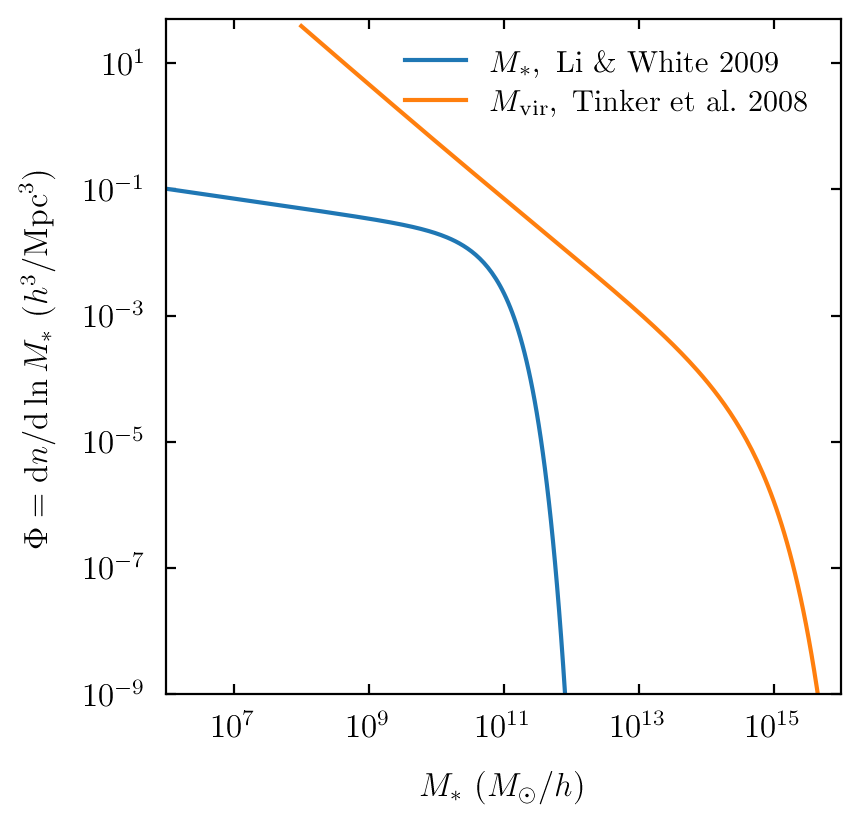

In [3]:
# Plot stellar mass function form Li & White. The function is the same as the luminosity 
# Schechter function but we rename the variables and allow the function to return
# different units.

from colossus.lss import mass_function

cosmo = cmn.cosmo
h = cosmo.h

# They give mstar in units of Msun / h^2, which we convert to Msun / h. The
# normalization phi_star is in h^3 / Mpc^3
M_knee = 10**10.525 / h
alpha = -1.155
phi_star = 0.0083
N_pts = 200
z = 0.0
mfunc_model = 'tinker08'

# Stellar mass function
ana_star_logm = np.linspace(6.0, 12.0, N_pts)
ana_star_m = 10**ana_star_logm
ana_star_mf = schechterFunctionMass(ana_star_m, phi_star, M_knee, alpha, units = 'dn_dlog10')

# Halo mass function
ana_halo_logm = np.linspace(8.0, 16, N_pts)
ana_halo_m = 10**ana_halo_logm
ana_halo_mf = mass_function.massFunction(ana_halo_m, z, q_in = 'M', q_out = 'dndlnM', 
                                         model = mfunc_model, mdef = 'vir')
ana_halo_mf *= np.log(10.0)

plt.figure()
plt.loglog()
plt.xlim(ana_star_m[0], ana_halo_m[-1])
plt.ylim(1E-9, 5E1)
plt.xlabel(r'$M_\ast\ (M_\odot / h)$')
plt.ylabel(r'$\Phi = {\rm d}n / {\rm d} \ln M_\ast\ (h^3 / {\rm Mpc}^3)$')
plt.plot(ana_star_m, ana_star_mf, label = r'$M_\ast,\ \mathrm{Li\ \&\ White\ 2009}$')
plt.plot(ana_halo_m, ana_halo_mf, label = r'$M_{\rm vir},\ \mathrm{Tinker\ et\ al.\ 2008}$')
plt.legend(loc = 1)
plt.show()

Let's compute the cumulative luminosity and mass function. We define a general function for this purpose, with integrand options for a Schechter function and the halo mass function.

In [4]:
import scipy

def integrandStar(logM, phi_star, M_knee, alpha):
    
    M = 10**logM
    x = schechterFunctionMass(M, phi_star, M_knee, alpha, units = 'dn_dlog10')
    
    return x

def integrandHalo(logM, z):
    
    M = 10**logM
    mf = mass_function.massFunction(M, z, q_in = 'M', q_out = 'dndlnM', model = mfunc_model, mdef = 'vir')
    mf *= np.log(10.0)
    
    return mf

def getCumulative(log_M, func, args = ()):
    
    cumu = np.zeros_like(log_M)
    for i in range(len(log_M) - 1, -1, -1):
        if i == len(log_M) - 1:
            cumu_last = 0.0
            upper_lim = 17.0
        else:
            cumu_last = cumu[i + 1]
            upper_lim = log_M[i + 1]
        I, _ = scipy.integrate.quad(func, log_M[i], upper_lim, args = args)
        cumu[i] = cumu_last + I

    return cumu

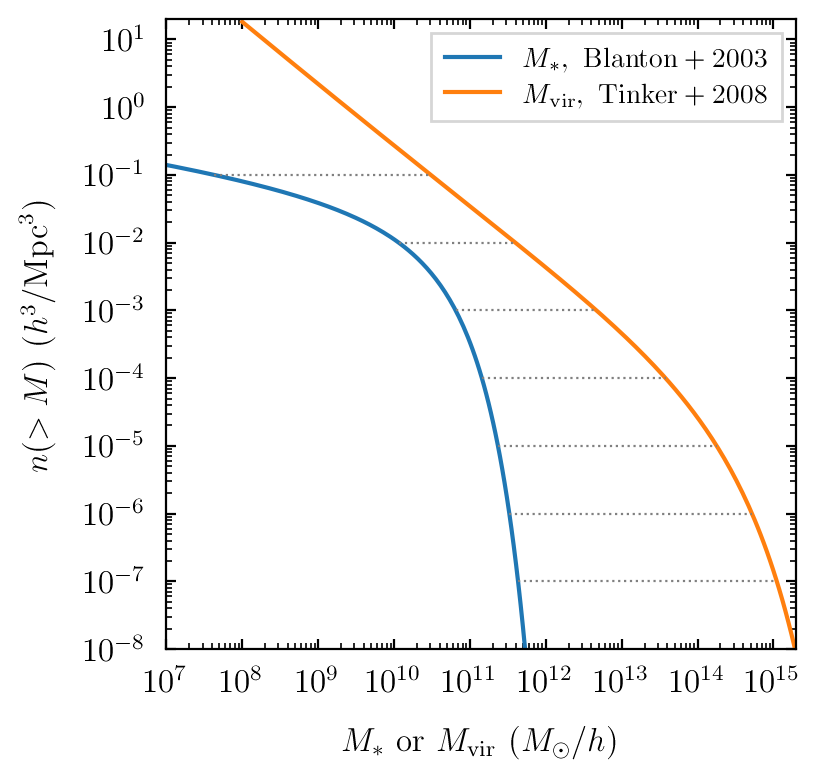

In [5]:
from matplotlib.ticker import LogLocator, MultipleLocator

ana_star_mf_cumu = getCumulative(ana_star_logm, integrandStar, args = (phi_star, M_knee, alpha))
ana_halo_mf_cumu = getCumulative(ana_halo_logm, integrandHalo, args = (z))

#The analytical way: Gamma function
#phi_cumu_ana = phi_star * scipy.special.gammaincc(alpha + 2.0, M_star / M_knee)

plt.figure()
plt.subplots_adjust(left = 0.25, bottom = 0.25)
plt.loglog()
plt.xlabel(r'$M_{\ast}\ {\rm or}\ M_{\rm vir}\ (M_\odot / h)$')
plt.ylabel(r'$n(>M)\ (h^3 / {\rm Mpc}^3)$')
plt.xlim(1E7, 2E15)
plt.ylim(1E-8, 2E1)
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(numticks = 100))
ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
ax.yaxis.set_major_locator(LogLocator(numticks = 100))
ax.yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

plt.plot(ana_star_m, ana_star_mf_cumu, label = r'$M_\ast,\ \mathrm{Blanton+2003}$')
#plt.plot(M_star, phi_cumu_ana, ':')
plt.plot(ana_halo_m, ana_halo_mf_cumu, label = r'$M_{\rm vir},\ \mathrm{Tinker+2008}$')

# Plot lines of constant n
plot_n = 10.0**np.arange(-7, 0, 1)
for n in plot_n:
    M_star_n = np.interp(n, ana_star_mf_cumu[::-1], ana_star_m[::-1])
    M_halo_n = np.interp(n, ana_halo_mf_cumu[::-1], ana_halo_m[::-1])
    plt.plot([M_star_n, M_halo_n], [n, n], ':', color = 'gray', lw = 0.8)
    
plt.legend(loc = 1, fontsize = 10, frameon = True)
plt.show()

We can see how the lines match galaxy masses to halo masses at fixed number density.

#### Abundance matching with simulated halos

The plot above is really promising, but we are making one significant mistake here: we are not including subhalos in the halo mass function, but the satellite galaxies living in the subhalos are included in the stellar mass function. We can fix this issue by directly using halo catalogs from the Erebos simulations. Here we use the peak mass a halo has ever attained in its history because subhalos tend to lose mass (which we will discuss in detail later in the course). The peak mass is thought to better correspond to the mass of the respective galaxies.

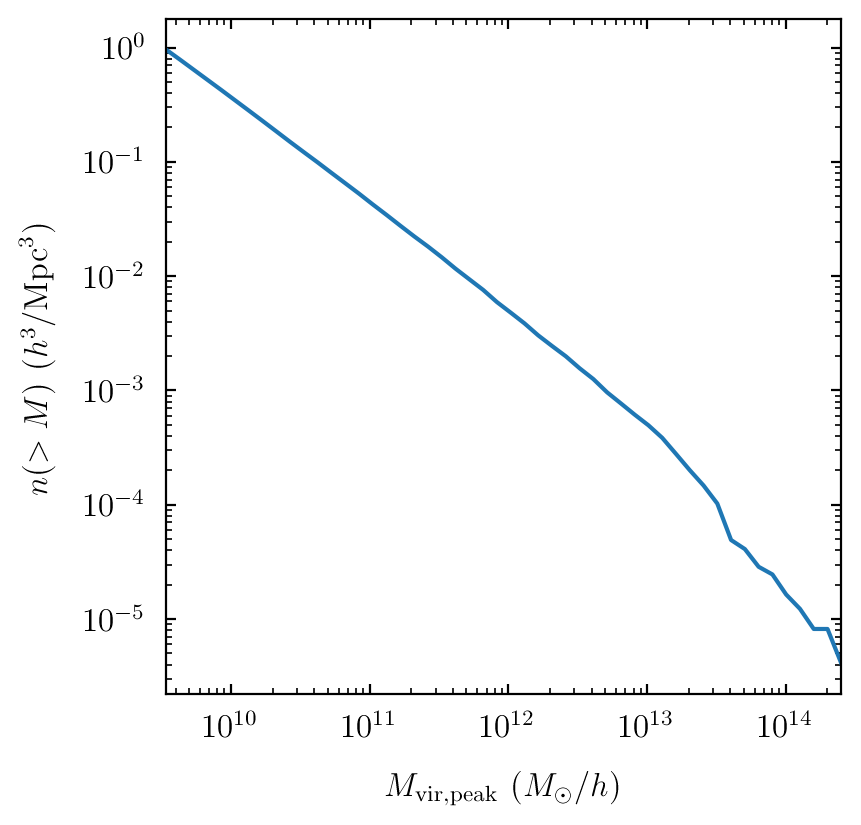

In [6]:
import h5py

def getCumulativeMassFunction(sim_name, min_n_ptl = 200, n_bins = 50):
    
    # Open file and load simulation info
    fn = cmn.data_dir + 'nbody/tree_%s.hdf5' % (sim_name)
    f = h5py.File(fn, 'r')
    L_box = f['simulation'].attrs['box_size']
    m_ptl = f['simulation'].attrs['particle_mass']
    mask_alive = np.array(f['mask_alive'][-1, :]).astype(bool)
    Mvir = np.array(f['Mvir'])
    f.close()

    # Limit array
    Mpeak = np.max(Mvir, axis = 0)
    M_min = m_ptl * min_n_ptl
    mask = (Mpeak >= M_min) & mask_alive
    Mpeak = Mpeak[mask]

    # Compute cumulative mass function
    mf, bin_edges = np.histogram(np.log10(Mpeak), bins = n_bins)
    bins = 10**bin_edges[:-1]
    mf_cumu = np.cumsum(mf[::-1])[::-1] / L_box**3
    
    return bins, mf_cumu

sim_name = 'l0063-bol'
sim_halo_m, sim_halo_mf_cumu = getCumulativeMassFunction(sim_name)

plt.figure()
plt.loglog()
plt.xlabel(r'$M_{\rm vir,peak}\ (M_\odot / h)$')
plt.ylabel(r'$n(>M)\ (h^3 / {\rm Mpc}^3)$')
plt.xlim(sim_halo_m[0], sim_halo_m[-1])
plt.plot(sim_halo_m, sim_halo_mf_cumu)
plt.show()

### 5.2) The stellar mass-halo mass relation

We now match the entire array of stellar masses to halo masses (since the stellar masses cover less range in number density). We do this with both the analytical and the simulated cumulative halo mass functions. We avoid the very lowest densities where the numbers get unreliable.

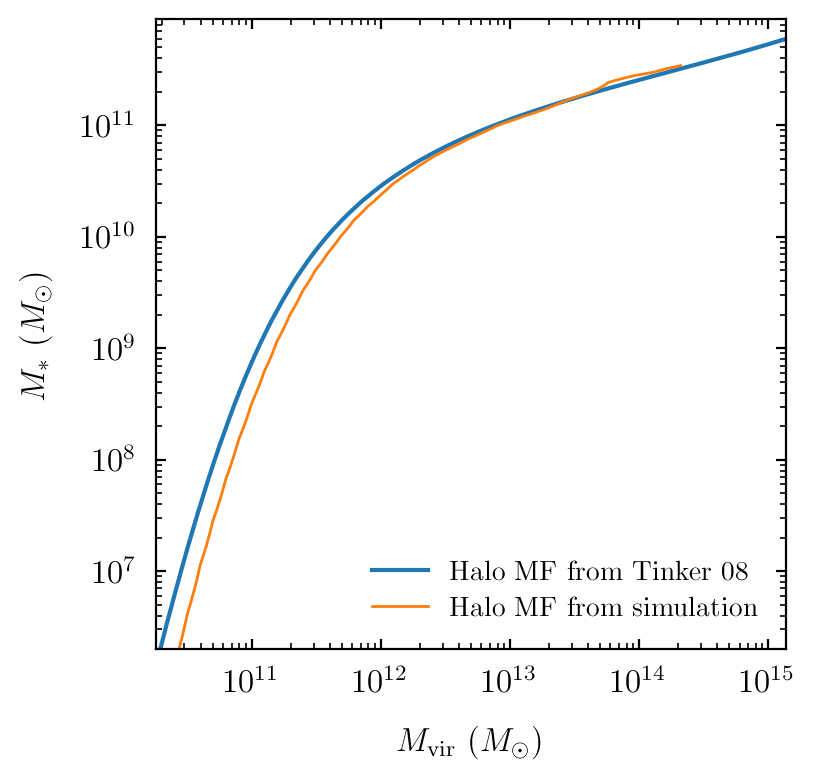

In [7]:
ana_mask = (ana_star_mf_cumu > 1E-7)
ana_matched_mhalo = np.interp(ana_star_mf_cumu[ana_mask], ana_halo_mf_cumu[::-1], ana_halo_m[::-1]) / h
ana_matched_mstar = ana_star_m[ana_mask] / h

sim_mask = (ana_star_mf_cumu > 1E-5)
sim_matched_mhalo = np.interp(ana_star_mf_cumu[sim_mask], sim_halo_mf_cumu[::-1], sim_halo_m[::-1]) / h
sim_matched_mstar = ana_star_m[sim_mask] / h

plt.figure()
plt.subplots_adjust(left = 0.25, bottom = 0.25)
plt.loglog()
plt.xlabel(r'$M_{\rm vir}\ (M_\odot)$')
plt.ylabel(r'$M_{\ast}\ (M_\odot)$')
plt.xlim(ana_matched_mhalo[0], ana_matched_mhalo[-1])
plt.ylim(2E6, 9E11)
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(numticks = 100))
ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
ax.yaxis.set_major_locator(LogLocator(numticks = 100))
ax.yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
plt.plot(ana_matched_mhalo, ana_matched_mstar, label = r'$\mathrm{Halo\ MF\ from\ Tinker\ 08}$')
plt.plot(sim_matched_mhalo, sim_matched_mstar, lw = 1.0, label = r'$\mathrm{Halo\ MF\ from\ simulation}$')
plt.legend(fontsize = 10)
plt.show()

Using the simulations directly leads to slightly lower stellar mass at fixed halo mass compared to the fitting function. This happens because the simulation results includes subhalos, which "take up" some fraction of galaxies at fixed mass and thus reduce the stellar mass available for halos at lower mass. At high masses the difference vanishes because only very few halos are subhalos.

We can make the message of this plot even clearer by plotting the ratio of stellar to halo mass. We compare to a number of observational results from [Behroozi et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...770...57B/abstract), [Kravtsov et al. 2018](https://ui.adsabs.harvard.edu/abs/2018AstL...44....8K/abstract), and [Munshi et al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...923...35M/abstract).

Maximum efficiency of creating stars is 19%


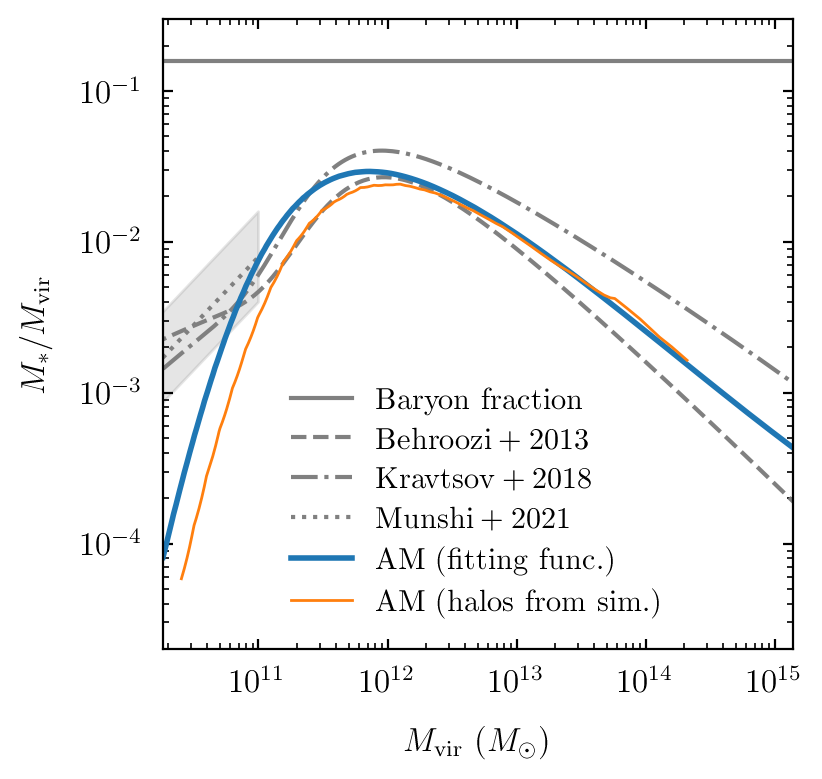

In [9]:
from routines import theory

baryon_frac = cosmo.Ob(0.0) / cosmo.Om(0.0)
max_eff = np.max(ana_matched_mstar / ana_matched_mhalo / baryon_frac)
print('Maximum efficiency of creating stars is %.0f%%'% (100.0 * max_eff))

beh_mvir, beh_shmr = theory.shmrBehroozi13()
kra_mvir, kra_shmr = theory.shmrKravtsov18()
mun_mvir, mun_shmr, mun_shmr_lo, mun_shmr_hi = theory.shmrMunshi21()

plt.figure()
plt.subplots_adjust(left = 0.25, bottom = 0.25)
plt.loglog()
plt.xlabel(r'$M_{\rm vir}\ (M_\odot)$')
plt.ylabel(r'$M_{\ast} / M_{\rm vir}$')
plt.xlim(ana_matched_mhalo[0], ana_matched_mhalo[-1])
plt.ylim(2E-5, 3E-1)
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(numticks = 100))
ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
ax.yaxis.set_major_locator(LogLocator(numticks = 100))
ax.yaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

plt.axhline(baryon_frac, ls = '-', color = 'gray', label = r'$\mathrm{Baryon\ fraction}$')

plt.plot(beh_mvir, beh_shmr, ls = '--', c = 'gray', label = r'$\mathrm{Behroozi+2013}$')
plt.plot(kra_mvir, kra_shmr, ls = '-.', c = 'gray', label = r'$\mathrm{Kravtsov+2018}$')
plt.fill_between(mun_mvir, mun_shmr_lo, mun_shmr_hi, color = 'gray', alpha = 0.2)
plt.plot(mun_mvir, mun_shmr, ls = ':', c = 'gray', label = r'$\mathrm{Munshi+2021}$')

plt.plot(ana_matched_mhalo, ana_matched_mstar / ana_matched_mhalo, lw = 2.0, color = cmn.color_cycle[0],
         label = r'$\mathrm{AM\ (fitting\ func.)}$')
plt.plot(sim_matched_mhalo, sim_matched_mstar / sim_matched_mhalo, lw = 1.0, color = cmn.color_cycle[1],
         label = r'$\mathrm{AM\ (halos\ from\ sim.)}$')

plt.legend(loc = 8, fontsize = 11)
plt.show()

If all halos got their fair share of baryons, and galaxies made all baryons into stars, the abundance-matched stellar masses should follow the solid gray line. The fact that they are way below that line means that galaxies are quite bad at producing stars! They are least bad around the Milky Way mass, $M \sim 10^{12}\ M_\odot$. But even there the efficiency is only about 20%.

Otherwise, our abundance matching agrees well with results from the literature above $M_{\rm vir} \sim 10^{11}\ M_\odot$. In the dwarf galaxy range, things get trickier. Our fitting function for the stellar mass function was not designed to cover this range.